In [1]:
# Usual ML imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)

# Keras stuff
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from plot_keras_history import plot_history

# OpenCV
import cv2

# Other modules
from pathlib import Path
from glob import glob

We build on the results of the previous notebook. The first thing we do is to load the dataset stored in the previous iteration. We also split the dataset into training and validation

In [2]:
dataset = np.load('../data/chinese_traffic_sign_dataset.npz')
X = dataset['X']
y = dataset['y']

(train_X, valid_X, train_Y, valid_Y) = train_test_split(X, y, test_size=0.2, stratify=y)

Plot a couple images just to make sure everything is fine

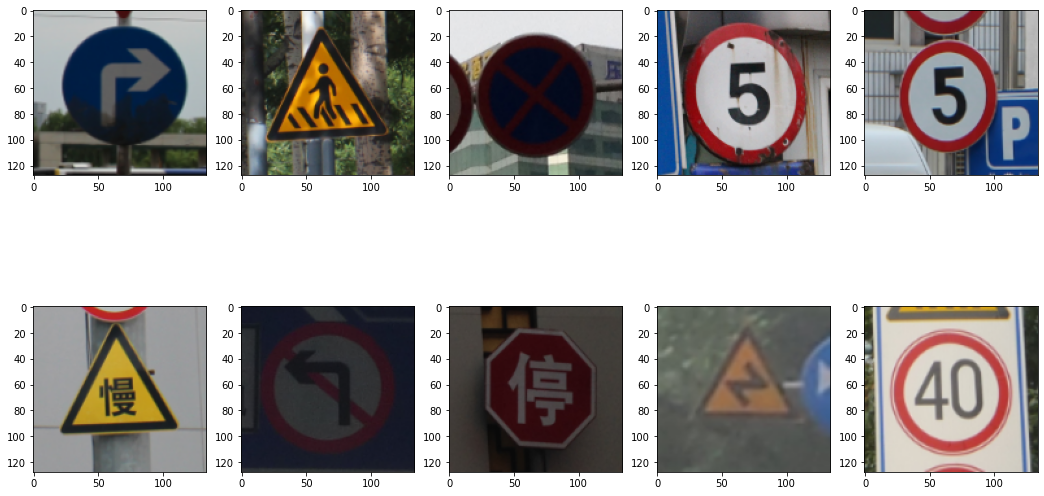

In [3]:
COLOR_LABEL = (255, 255, 255)
THICKNESS = 2
FONT_SCALE = 1
idxs_train = (27, 176, 1464, 3111, 1981)
idxs_valid = (19, 555, 101, 127, 454)
LENGTH = len(idxs_train)

imgs_train = []
imgs_valid = []

for i in range(LENGTH):
    imgs_train.append(train_X[idxs_train[i]])
    imgs_valid.append(valid_X[idxs_valid[i]])


# for i in range(LENGTH):
#     label_train = np.where(train_Y[idxs_train[i]] == 1)[0]
#     cv2.putText(imgs_train[i], str(label_train), (50, 50), 0, FONT_SCALE, COLOR_LABEL, THICKNESS//2)
#     label_valid = np.where(valid_Y[idxs_valid[i]] == 1)[0]
#     cv2.putText(imgs_valid[i], str(label_valid), (50, 50), 0, FONT_SCALE, COLOR_LABEL, THICKNESS//2)


for k in range(LENGTH):
    plt.subplot(2, LENGTH, k+1)
    plt.imshow(imgs_train[k])
    plt.subplot(2, LENGTH, k+LENGTH+1)
    plt.imshow(imgs_valid[k])

Ok we now define the CNN that we will use for training the model

In [4]:
def create_model(input_dims, num_classes):
    model = model = Sequential()
    
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_dims))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Conv2D(32, (5, 5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Flatten())  
    model.add(Dense(64, activation='relu',))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
     
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

CNN = create_model(X[0,:].shape, y.shape[1])

Now we start training the model. We will do that for 30 epochs, and track the accuracy over each epoch. We apply several augmentations to the training set to enhance generalization.

In [5]:
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

MODEL_NAME = 'chinese_traffic_sign_classifier_v1.h5'
NUM_EPOCHS = 30
BATCH_SIZE = 100

checkpoint = ModelCheckpoint(MODEL_NAME, save_best_only=True, monitor='accuracy', mode='auto') 

h = CNN.fit(trainAug.flow(train_X, train_Y, batch_size=BATCH_SIZE), steps_per_epoch=len(train_X) // BATCH_SIZE,
    validation_data=(valid_X, valid_Y), validation_steps=len(valid_X) // BATCH_SIZE, callbacks=[checkpoint],
    epochs=NUM_EPOCHS)

Epoch 1/30
33/33 [==============================] - 30s 870ms/step - loss: 3.6614 - accuracy: 0.1233 - val_loss: 3.1746 - val_accuracy: 0.2350
Epoch 2/30
33/33 [==============================] - 36s 1s/step - loss: 2.9984 - accuracy: 0.2543 - val_loss: 2.5336 - val_accuracy: 0.3609
Epoch 3/30
33/33 [==============================] - 31s 927ms/step - loss: 2.4905 - accuracy: 0.3492 - val_loss: 2.1269 - val_accuracy: 0.4580
Epoch 4/30
33/33 [==============================] - 27s 820ms/step - loss: 2.1172 - accuracy: 0.4317 - val_loss: 1.8187 - val_accuracy: 0.5072
Epoch 5/30
33/33 [==============================] - 41s 1s/step - loss: 1.7979 - accuracy: 0.5053 - val_loss: 1.4320 - val_accuracy: 0.6499
Epoch 6/30
33/33 [==============================] - 30s 902ms/step - loss: 1.5474 - accuracy: 0.5624 - val_loss: 1.2338 - val_accuracy: 0.6679
Epoch 7/30
33/33 [==============================] - 29s 880ms/step - loss: 1.3195 - accuracy: 0.6320 - val_loss: 1.0139 - val_accuracy: 0.7278
Epoch

Let's plot the accuracy and loss over time

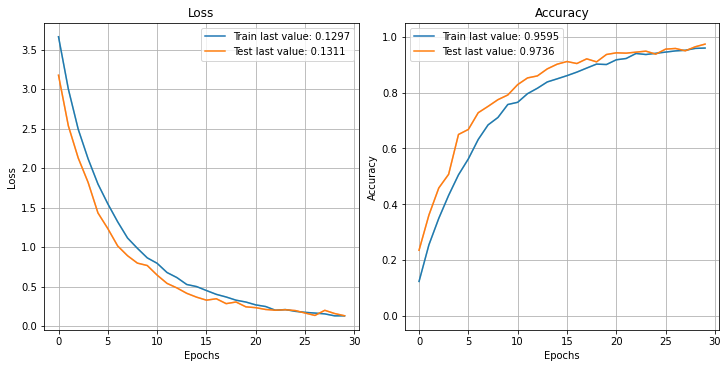

In [6]:
plot_history(h.history)
plt.show()

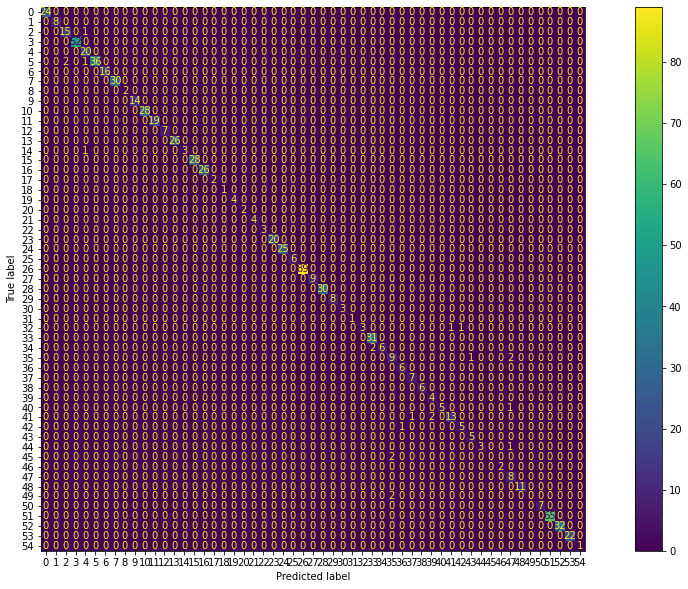

In [7]:
predIdxs = CNN.predict(valid_X, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)

cm = confusion_matrix(valid_Y.argmax(axis=1), predIdxs)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()